In [1]:
include("src/Models.jl")
include("src/Params.jl")
include("src/Utils.jl")

using DifferentialEquations
using Plots; gr();

Intrinsic period. Given \[KaiA\] = 1.0 uM the period should solve to 23.2 hours.

In [2]:
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]
A0 = 1.0
fATP = 1.0
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]
_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500, p)
Tbase

23.215001853643642

What is the perturbation?

The perturbation is assumed to be a step growth where protein is synthesized and volume expands.
Protein synthesis rate exactly matches the volume expansion rate so that the total concentration of each Kai protein stays the same.
However, only U-KaiC is assumed to be synthesized. If volume is expanded $\gamma$ compared to before,

$$
[U]_{new} = \frac{[U]_{old} + \gamma [C]_{tot}}{1 + \gamma}\\
[P]_{new} = \frac{[P]_{old}}{1 + \gamma}
$$

Where $P \in {S, T, D}$.

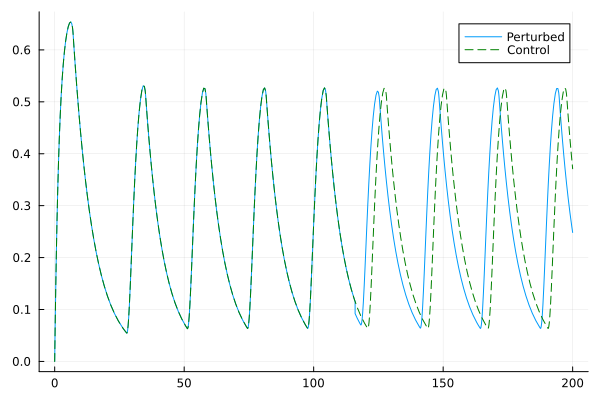

T perturb: 16 Phase shift: 0.8036409754626845


In [4]:
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]

X0 = [U0, 0, 0, 0, 0, 0]

m = 0.25    # ratio of increase in conc
tperturb = 16
tstab = 100.0    # t where perturbation is applied = tperturb + tstab

function affect!(integrator)
    Ctot = sum(integrator.u)
    integrator.u[1] += m*Ctot
    # normalize to enforce C-to-A ratio
    integrator.u /= 1 + m
end

cb = PresetTimeCallback(tstab + tperturb, affect!)

prob = ODEProblem(kaiabc_phong!, X0, (0.0, 200.0), p)
sol = solve(prob, callback=cb, reltol=1e-8, abstol=1e-8)
prob_ori = ODEProblem(kaiabc_phong!, X0, (0.0, 200.0), p)
sol_ori = solve(prob, reltol=1e-8, abstol=1e-8)

plot(sol.t, phospho_C(sol.u), fmt=:png, label="Perturbed")
plot!(sol_ori.t, phospho_C(sol_ori.u), color=:green, linestyle=:dash, label="Control") |> display

# phase without perturbation
# don't worry: attracted_to() is safe in the sense that p will be copied in each solution
_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500.0, p, avg_window=32)

# phase after perturbation
converge, A, T, ϕ = attracted_to(kaiabc_phong!, X0, 500.0, p, callback=cb, burnin=2*tstab, avg_window=32, conv_tol=5e-3)
    
ϕjump = mod2pi(ϕ + (tstab + tperturb)/T*2π)
ϕbase_jump = mod2pi(ϕbase + (tstab + tperturb)/Tbase*2π)
Δϕ = ϕjump - ϕbase_jump
println("T perturb: ", tperturb, " Phase shift: ", Δϕ)

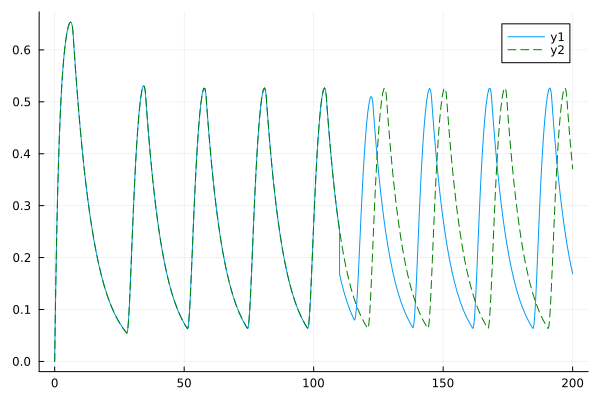

T perturb: 10 Phase shift: 1.5770364544308646


In [6]:
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]

m = 0.5    # ratio of increase in conc
tperturb = 10
tstab = 100.0    # t where perturbation is applied = tperturb + tstab

function affect!(integrator)
    Ctot = sum(integrator.u)
    integrator.u[1] += m*Ctot
    # normalize to enforce C-to-A ratio
    integrator.u /= 1 + m
end

cb = PresetTimeCallback(tstab + tperturb, affect!)

prob = ODEProblem(kaiabc_phong!, X0, (0.0, 200.0), p)
sol = solve(prob, callback=cb, reltol=1e-8, abstol=1e-8)
prob_ori = ODEProblem(kaiabc_phong!, X0, (0.0, 200.0), p)
sol_ori = solve(prob_ori, reltol=1e-8, abstol=1e-8)

plot(sol.t, phospho_C(sol.u))
plot!(sol_ori.t, phospho_C(sol_ori.u), color=:green, linestyle=:dash) |> display

# phase without perturbation
_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500.0, p, avg_window=32)

# phase after perturbation
converge, A, T, ϕ = attracted_to(kaiabc_phong!, X0, 500.0, p, callback=cb, burnin=2*tstab, avg_window=32, conv_tol=5e-3)
    
ϕjump = mod2pi(ϕ + (tstab + tperturb)/T*2π)
ϕbase_jump = mod2pi(ϕbase + (tstab + tperturb)/Tbase*2π)
Δϕ = ϕjump - ϕbase_jump
println("T perturb: ", tperturb, " Phase shift: ", Δϕ)

In [9]:
# params
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]
A0 = 1.5
fATP = 1.0
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]

m = 0.1    # ratio of increase in conc
tstab = 100.0    # t where perturbation is applied = tperturb + tstab

# define the jump
function affect!(integrator)
    Ctot = sum(integrator.u)
    integrator.u[1] += m*Ctot
    # normalize to enforce C-to-A ratio
    integrator.u /= 1 + m
end

_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500.0, p, avg_window=32)
tperturb_vec = (0:1/72:1) .* Tbase
#tperturb_vec = [0.2, 1.2]*Tbase

ϕ_vec = zeros(length(tperturb_vec))

for i = 1:length(tperturb_vec)
    
    cb = PresetTimeCallback(tstab + tperturb_vec[i], affect!)
    converge, A, T, ϕ = attracted_to(kaiabc_phong!, X0, 500.0, p, callback=cb, burnin=2*tstab, avg_window=32, conv_tol=5e-3)
    
    ϕjump = mod2pi(ϕ + (tstab + tperturb_vec[i])/T*2π)
    ϕbase_jump = mod2pi(ϕbase + (tstab + tperturb_vec[i])/Tbase*2π)
    Δϕ = ϕjump - ϕbase_jump
    ϕ_vec[i] = Δϕ

    println("T perturb: ", tperturb_vec[i], " Phase shift: ", Δϕ)
end

T perturb: 0.0 Phase shift: 0.2190541040460765
T perturb: 0.39298105308936754 Phase shift: 0.21799897677272995
T perturb: 0.7859621061787351 Phase shift: 0.23941250956358928
T perturb: 1.1789431592681026 Phase shift: 0.2413296253829209
T perturb: 1.5719242123574702 Phase shift: 0.23649861338098788
T perturb: 1.9649052654468377 Phase shift: 0.2310416885966049
T perturb: 2.357886318536205 Phase shift: 0.21589086582160988
T perturb: 2.750867371625573 Phase shift: 0.2426454541649825
T perturb: 3.1438484247149403 Phase shift: 0.23532309375890748
T perturb: 3.5368294778043077 Phase shift: 0.23175739602968193
T perturb: 3.9298105308936755 Phase shift: 0.22740377822544744
T perturb: 4.322791583983043 Phase shift: 0.2156424033134634
T perturb: 4.71577263707241 Phase shift: 0.22543794923879545
T perturb: 5.108753690161778 Phase shift: 0.23574068279046045
T perturb: 5.501734743251146 Phase shift: 0.2280227929065397
T perturb: 5.894715796340513 Phase shift: 0.23081500512461162
T perturb: 6.2876968

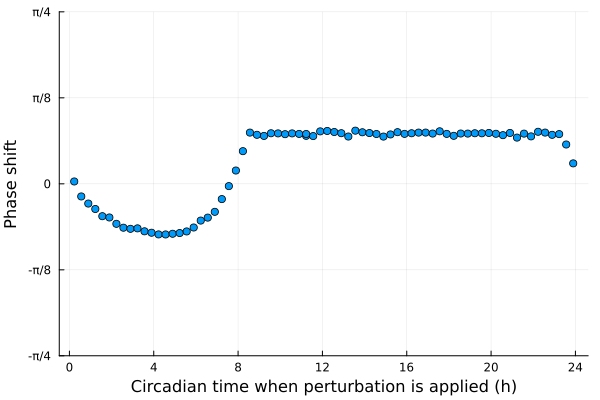

In [12]:
ϕperturb_vec = @. mod2pi(ϕbase + (tstab + tperturb_vec)/Tbase*2π)
CTperturb_vec = ϕperturb_vec./2π.*24
scatter(CTperturb_vec, [ϕ > π ? ϕ - 2π : ϕ for ϕ in mod2pi.(ϕ_vec)],
    xlabel="Circadian time when perturbation is applied (h)", 
    ylabel="Phase shift", linewidth=2, leg=false, fmt=:png)
yticks!(([-π, -π/2, -π/4, -π/8, 0, π/8, π/4, π/2, π], ["-π", "-π/2", "-π/4", "-π/8", "0", "π/8", "π/4", "π/2", "π"]))
ylims!((-π/4, π/4))
xticks!(0:4:24)

# simple = (ϕ, p) -> -2p*sin(ϕ)
# scatter!(CTperturb_vec, (x -> simple(x, γ)).(ϕperturb_vec), markersize=2)

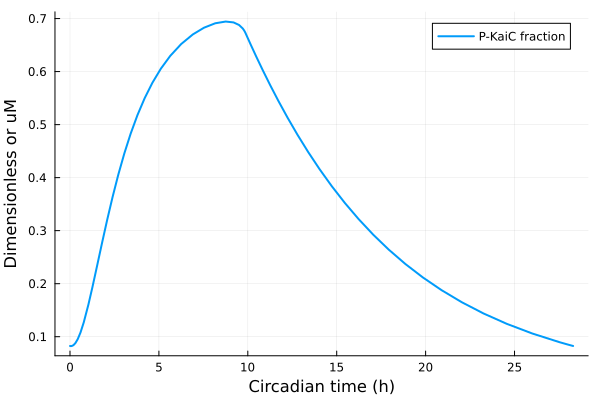

In [15]:
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]
A0 = 1.5
fATP = 1.0
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]

_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500.0, p, conv_tol=5e-3, avg_window=32)

prob = ODEProblem(kaiabc_phong!, X0, (0.0, 500.0), p)
sol = solve(prob, reltol=1e-8, abstol=1e-8)
pC = phospho_C(sol.u)

tstart = (2π - ϕbase)/2π*Tbase + 4*Tbase
ind = tstart .<= sol.t .<= tstart + Tbase
pp = plot(sol.t[ind] .- tstart, pC[ind], xlabel="Circadian time (h)", ylabel="Dimensionless or uM", 
    linewidth=2, label="P-KaiC fraction", fmt=:png)
display(pp)